<a href="https://colab.research.google.com/github/aamirigithub/AI4Cyber/blob/main/AI4Cyber_Phishing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tld

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 18.3 MB/s eta 0:00:00


# Importing Libraries & Dataset

In [2]:
import pandas as pd
import numpy as np
import itertools
import sklearn.metrics as metrics
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, precision_score
from sklearn.model_selection import train_test_split

import xgboost as xgb
from lightgbm import LGBMClassifier
import os

# Interactive Visualization for Python
import matplotlib.pyplot as plt

# Statistical Data Visualization
import seaborn as sns

# Visually identify the concentration of data
from wordcloud import WordCloud

# load the dataset
df=pd.read_csv('malicious_phish.csv')
# Privide shape
print(df.shape) 
# Load as table
df.head()

(590969, 2)


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [3]:
# Number of counts each label
df.type.value_counts()

benign        367881
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

In [5]:
# Word cloud represent the frequency or the importance of each word and it Quickly identify 
# the most important words in a large body of text to Understand the patterns or trends in data visually.

df_phish = df[df.type=='phishing']
df_malware = df[df.type=='malware']
df_deface = df[df.type=='defacement']
df_benign = df[df.type=='benign']


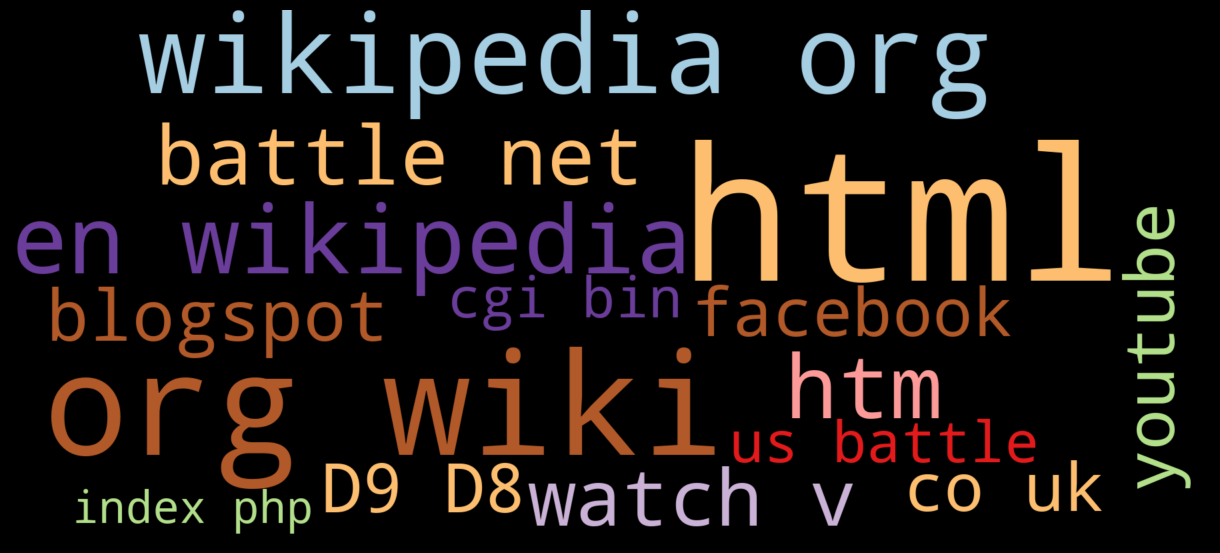

In [9]:
# Identify concentration of Benign URL
benign_url = " ".join(i for i in df_benign.url)
wordcloud = WordCloud(background_color="black", max_words=15, width=1800, height=800,colormap='Paired').generate(benign_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

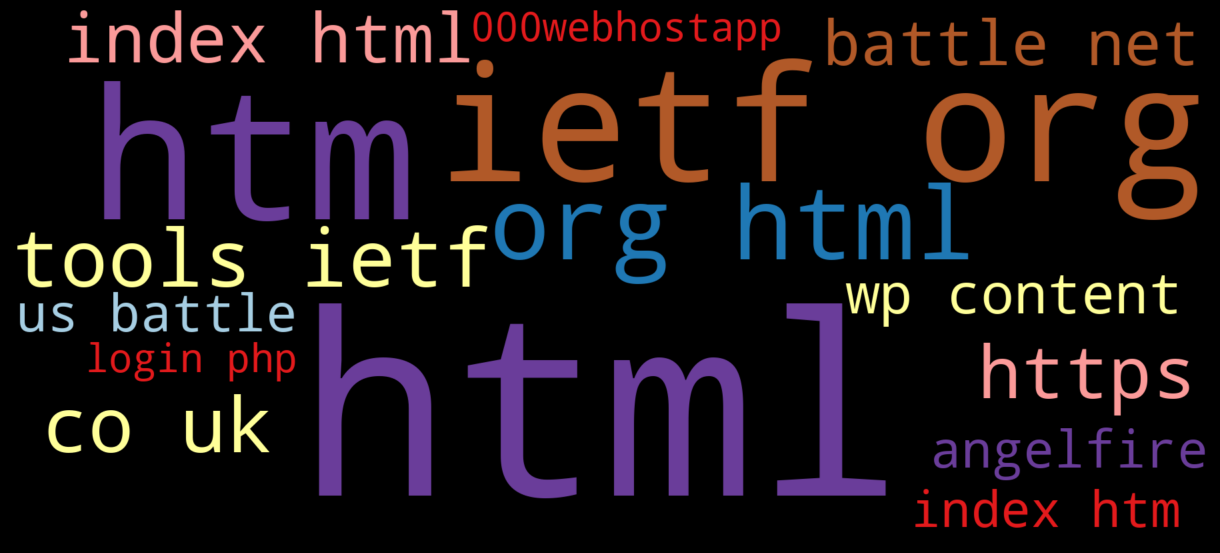

In [10]:
# Identify concentration of Phishing URL
phish_url = " ".join(i for i in df_phish.url)
wordcloud = WordCloud(background_color="black", max_words=15, width=1800, height=800, colormap='Paired').generate(phish_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

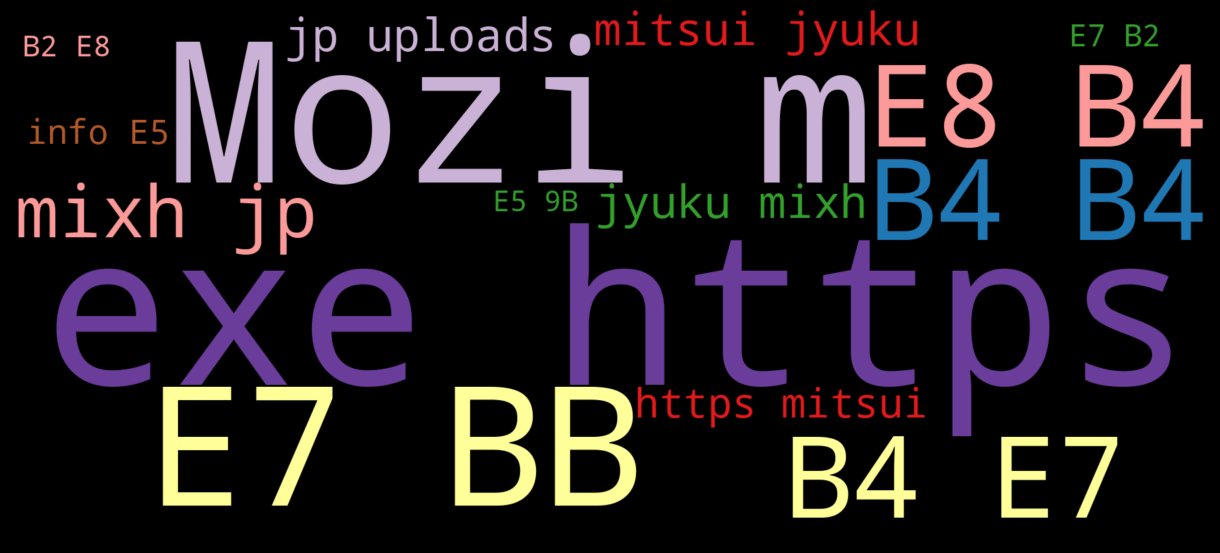

In [7]:
# Identify concentration of Malware URL
malware_url = " ".join(i for i in df_malware.url)
wordcloud = WordCloud(background_color="black", max_words=15, width=1800, height=800,colormap='Paired').generate(malware_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

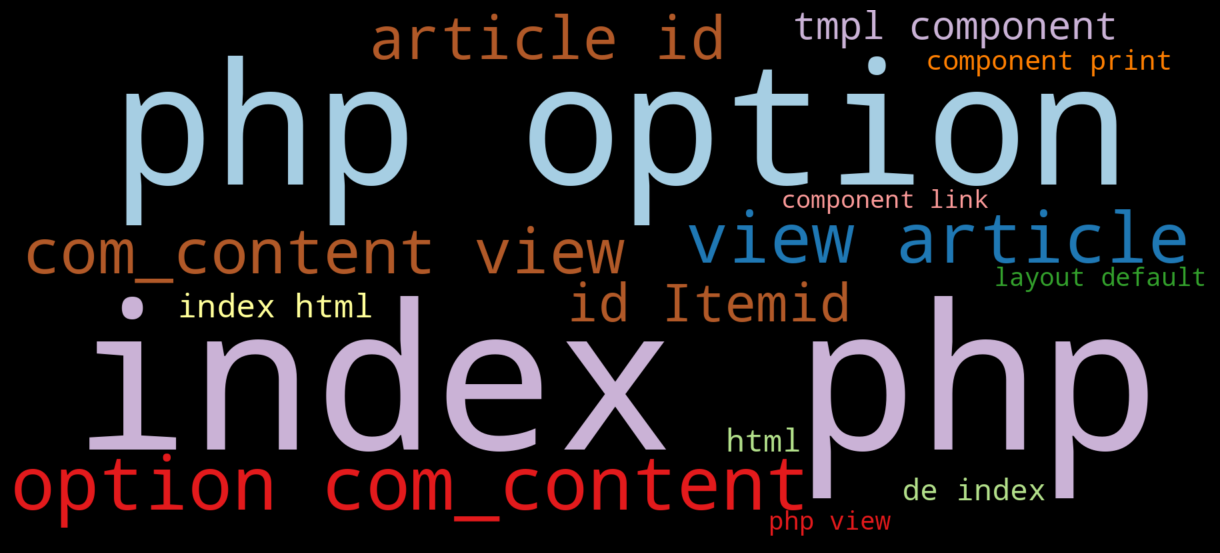

In [8]:
# Identify concentration of Defacement URL
deface_url = " ".join(i for i in df_deface.url)
wordcloud = WordCloud(background_color="black", max_words=15, width=1800, height=800,colormap='Paired').generate(deface_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# Lexical Feature engineering

In [11]:
import re
# Identify URLs with an IP address, i.e., having_ip_address() function. 
# If the URL contains an IP address, the function returns 1; otherwise, it returns 0. 
# The result is then added to a new column called "use_of_ip" in the DataFrame "df".

def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0
df['use_of_ip'] = df['url'].apply(lambda i: having_ip_address(i))

# The code uses the urlparse() function from the urllib.parse library to extract the hostname from the URL. 
# It then compares the hostname with the URL to detect any abnormalities in the URL, 
# i.e., abnormal_url() function. If the URL contains any abnormalities, the function returns 1; otherwise, it returns 0. 
# The result is then added to a new column called "abnormal_url" in the DataFrame "df".

from urllib.parse import urlparse

def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0


df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))

# The code uses the Google Search API (googlesearch-python library) to check if the URL is indexed by Google or not, 
# i.e., google_index() function. If the URL is indexed by Google, the function returns 1; otherwise, it returns 0. 
# The result is then added to a new column called "google_index" in the DataFrame "df".

# pip install googlesearch-python

from googlesearch import search

def google_index(url):
    site = search(url, 5)
    return 1 if site else 0
df['google_index'] = df['url'].apply(lambda i: google_index(i))

# The code defines several functions that count the number of dots, www, @, /, and // in the URL, respectively. 
# Each function takes the URL as input and returns the count of the corresponding element. 
# The results are then added to new columns in the DataFrame "df".

def count_dot(url):
    count_dot = url.count('.')
    return count_dot

df['count.'] = df['url'].apply(lambda i: count_dot(i))

def count_www(url):
    url.count('www')
    return url.count('www')

df['count-www'] = df['url'].apply(lambda i: count_www(i))

def count_atrate(url):
     
    return url.count('@')

df['count@'] = df['url'].apply(lambda i: count_atrate(i))


def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')

df['count_dir'] = df['url'].apply(lambda i: no_of_dir(i))

def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')

df['count_embed_domian'] = df['url'].apply(lambda i: no_of_embed(i))

# The code defines a function to detect URL shortening services, i.e., shortening_service() function. 
# If the URL uses a shortening service, the function returns 1; otherwise, it returns 0. 
# The result is then added to a new column called "short_url" in the DataFrame "df".

def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0
    
df['short_url'] = df['url'].apply(lambda i: shortening_service(i))

# The code defines several functions that count the number of occurrences of "https", "http", "%", "?", and "-" in the URL, respectively. 
# Each function takes the URL as input and returns the count of the corresponding element. 
# The results are then added to new columns in the DataFrame "df".

def count_https(url):
    return url.count('https')

df['count-https'] = df['url'].apply(lambda i : count_https(i))

def count_http(url):
    return url.count('http')

df['count-http'] = df['url'].apply(lambda i : count_http(i))

def count_per(url):
    return url.count('%')

df['count%'] = df['url'].apply(lambda i : count_per(i))

def count_ques(url):
    return url.count('?')

df['count?'] = df['url'].apply(lambda i: count_ques(i))

def count_hyphen(url):
    return url.count('-')

df['count-'] = df['url'].apply(lambda i: count_hyphen(i))

def count_equal(url):
    return url.count('=')

df['count='] = df['url'].apply(lambda i: count_equal(i))

def url_length(url):
    return len(str(url))

###############
# Length of URL

df['url_length'] = df['url'].apply(lambda i: url_length(i))

#################
# Hostname Length

def hostname_length(url):
    return len(urlparse(url).netloc)

df['hostname_length'] = df['url'].apply(lambda i: hostname_length(i))

df.head()

def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    if match:
        return 1
    else:
        return 0
df['sus_url'] = df['url'].apply(lambda i: suspicious_words(i))


def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits


df['count-digits']= df['url'].apply(lambda i: digit_count(i))


def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

df['count-letters']= df['url'].apply(lambda i: letter_count(i))

# Find top level domain
# pip install tld

from urllib.parse import urlparse
from tld import get_tld
import os.path

# First Directory Length
def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

df['fd_length'] = df['url'].apply(lambda i: fd_length(i))

# Length of Top Level Domain
df['tld'] = df['url'].apply(lambda i: get_tld(i,fail_silently=True))


def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

df['tld_length'] = df['tld'].apply(lambda i: tld_length(i))

In [12]:
df = df.drop("tld", 1)

df.columns


<ipython-input-12-59c9989b81b8>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop("tld", 1)


Index(['url', 'type', 'use_of_ip', 'abnormal_url', 'google_index', 'count.',
       'count-www', 'count@', 'count_dir', 'count_embed_domian', 'short_url',
       'count-https', 'count-http', 'count%', 'count?', 'count-', 'count=',
       'url_length', 'hostname_length', 'sus_url', 'count-digits',
       'count-letters', 'fd_length', 'tld_length'],
      dtype='object')

In [13]:
print(df.shape)

(590969, 24)


In [14]:
df['use_of_ip'].value_counts()

0    583686
1      7283
Name: use_of_ip, dtype: int64

In [15]:
df.head()

,url,type,use_of_ip,abnormal_url,google_index,count.,count-www,count@,count_dir,count_embed_domian,...,count?,count-,count=,url_length,hostname_length,sus_url,count-digits,count-letters,fd_length,tld_length
0,br-icloud.com.br,phishing,0,0,1,2,0,0,0,0,...,0,1,0,16,0,0,0,13,0,-1
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2,0,0,2,0,...,0,0,0,35,0,0,1,29,5,-1
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2,0,0,3,0,...,0,0,0,31,0,0,1,25,7,-1
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3,1,0,1,0,...,1,1,4,88,21,0,7,63,9,2
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2,0,0,1,0,...,1,1,3,235,23,0,22,199,9,3


<Axes: xlabel='type', ylabel='count'>

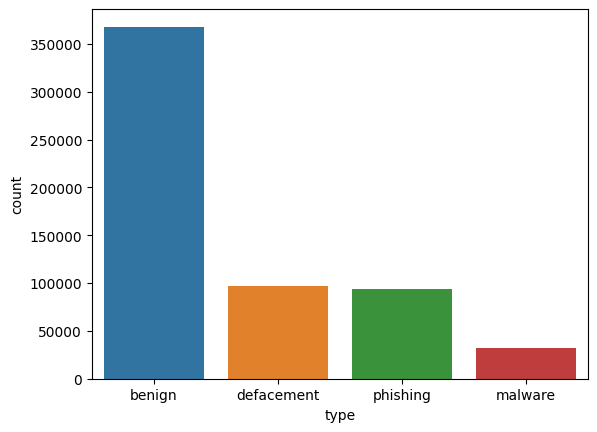

In [16]:
# Visualize the distribution of domain URL data type
sns.countplot(data = df, x = 'type', order = df['type'].value_counts().index)

In [17]:
df[['use_of_ip', 'abnormal_url', 'short_url', 'sus_url']].value_counts()

use_of_ip  abnormal_url  short_url  sus_url
0          0             0          0          351680
           1             0          0          157189
           0             0          1           28842
                         1          0           26062
           1             0          1           10339
1          1             0          0            7051
0          1             1          0            7014
           0             1          1            1899
           1             1          1             661
1          1             0          1             149
           0             0          0              66
                                    1              16
           1             1          0               1
dtype: int64

# IP Addresses Distribution

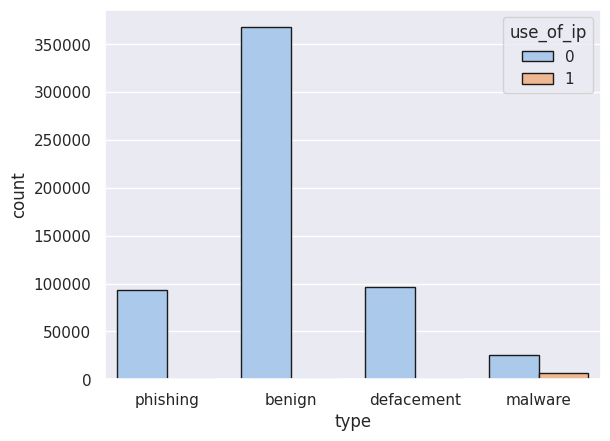

In [14]:
#sns.set(style='darkgrid')
sns.set_theme()
sns.color_palette("Blues", as_cmap=True)
ax = sns.countplot(data = df, x="type", hue="use_of_ip", palette="pastel", edgecolor=".1")

# Abnormal URL Distribution

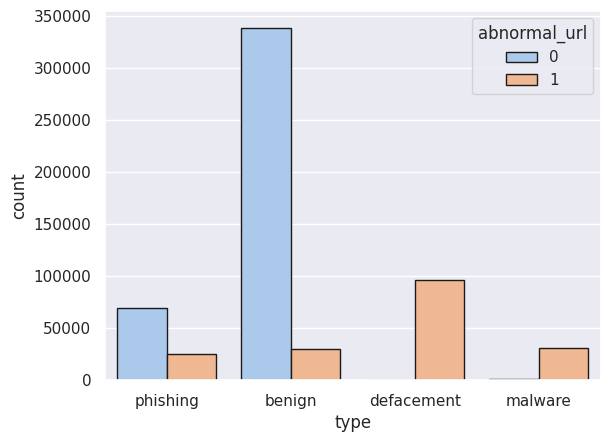

In [15]:
#sns.set(style='darkgrid')
ax = sns.countplot(x ="type", data=df,hue="abnormal_url", palette="pastel", edgecolor=".1")

# Google Index Distribution

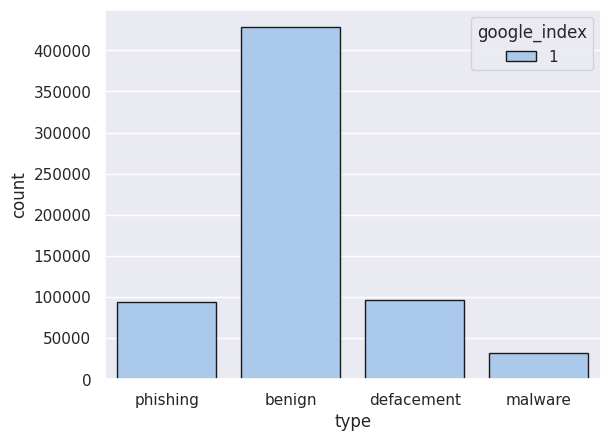

In [104]:
#sns.set(style='darkgrid')
ax = sns.countplot(x ="type", data=df,hue="google_index", palette="pastel", edgecolor=".1")

# Short URL Distribution

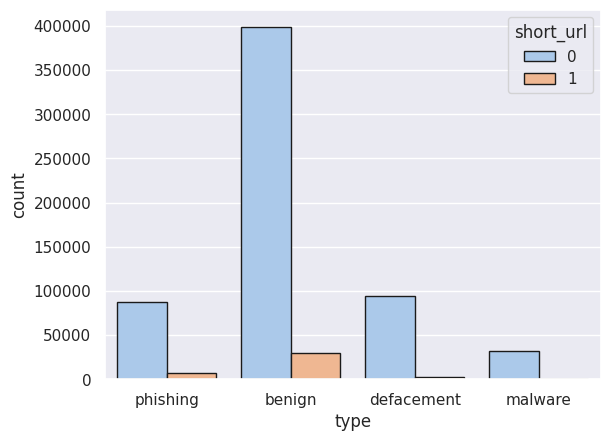

In [105]:
#sns.set(style='darkgrid')
ax = sns.countplot(x ="type", data=df,hue="short_url", palette="pastel", edgecolor=".1")

# Suspecious URL Distribution

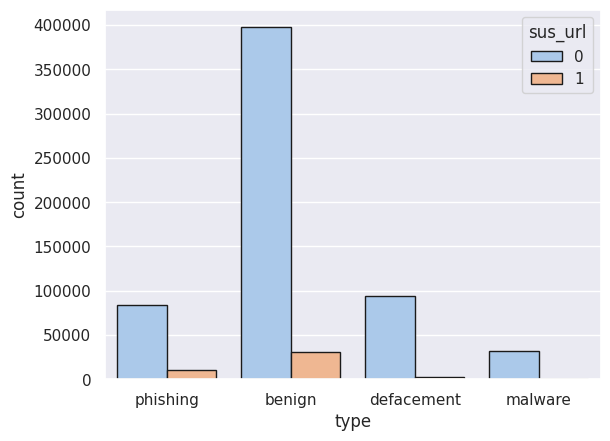

In [106]:
#sns.set(style='darkgrid')
ax = sns.countplot(x ="type", data=df, hue="sus_url", palette="pastel", edgecolor=".1")

# Categorical scatterplots

# Count Dots Distribution

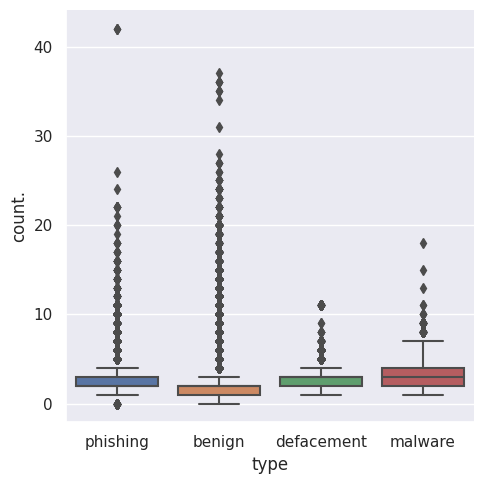

In [107]:
# Comparing "." distributions
ax = sns.catplot(x="type", y="count.", kind="box", data=df)

# Count WWW Distribution

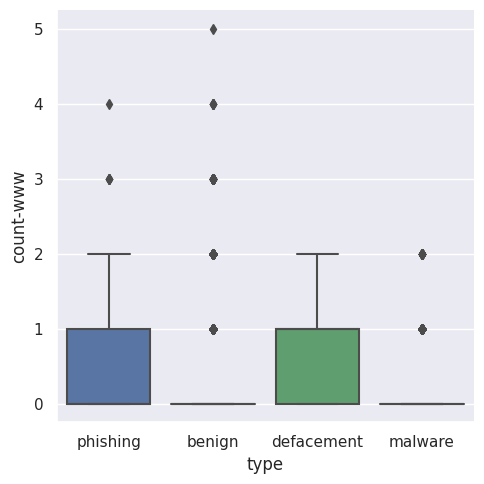

In [108]:
# Comparing "www" distributions
ax = sns.catplot(x="type", y="count-www", kind="box", data=df)

# Count @ Distribution

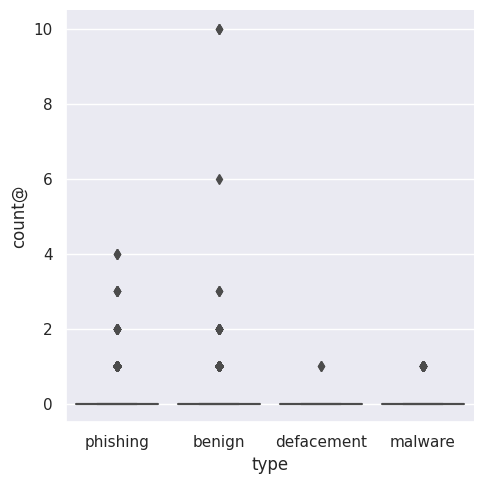

In [109]:
# Comparing "@" distributions
ax = sns.catplot(x="type", y="count@", kind="box", data=df)

# Count Directories Distribution

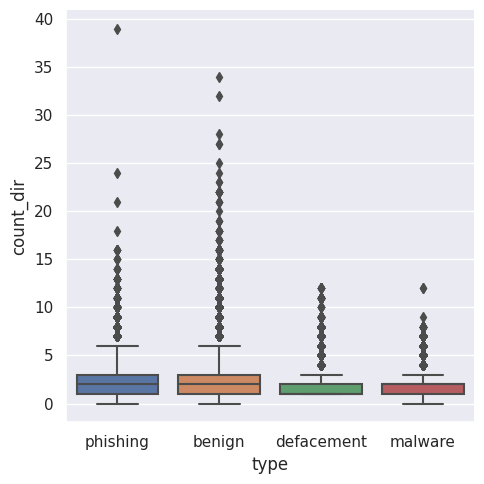

In [110]:
# Comparing "/" distributions
ax = sns.catplot(x="type", y="count_dir", kind="box", data=df)

# Hostname Length Distribution

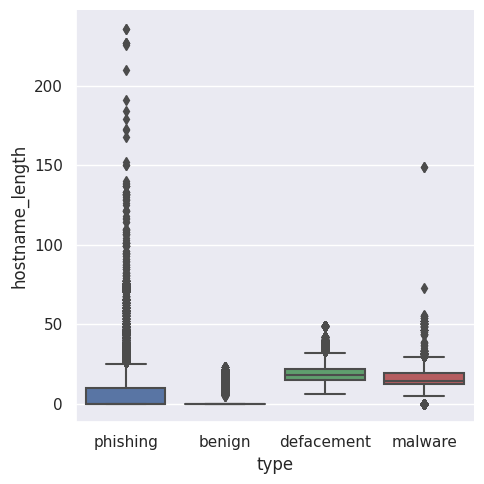

In [111]:
# Comparing "Hostname Length" distributions
ax = sns.catplot(x="type", y="hostname_length", kind="box", data=df)

# First Directory Length Distribution

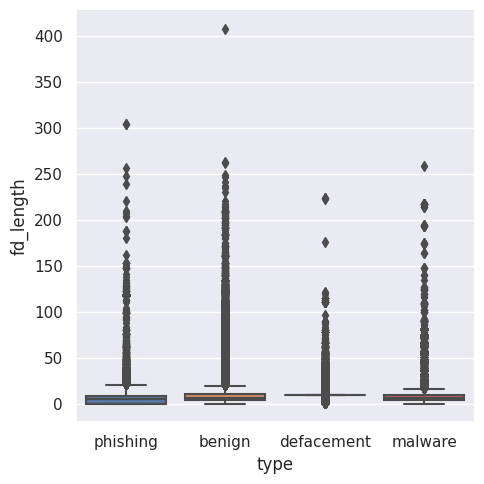

In [112]:
# Comparing "First Directory Length" distributions
ax = sns.catplot(x="type", y="fd_length", kind="box", data=df)

# Top Level Domain Length Distribution

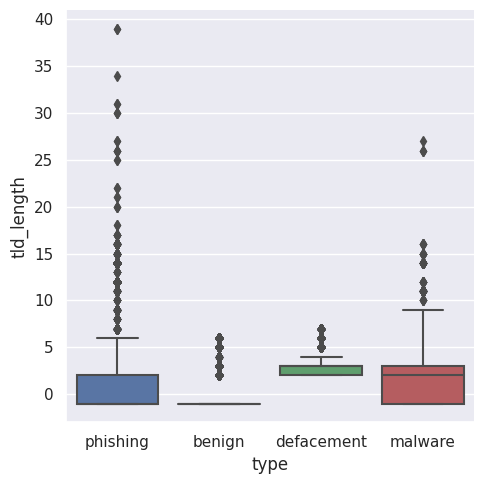

In [113]:
# Comparing "TLD Length" distributions
ax = sns.catplot(x="type", y="tld_length", kind="box", data=df)

# Label Encoding

In [19]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
df["type_code"] = lb_make.fit_transform(df["type"])
df["type_code"].value_counts()

0    367881
1     96457
3     94111
2     32520
Name: type_code, dtype: int64

# Creating Features and Targets

In [20]:
# Predictor Variables
# filtering out google_index as it has only 1 value
X = df[['use_of_ip','abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters']]

#Target Variable
y = df['type_code']
X.head()

,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,short_url,count-https,count-http,...,count?,count-,count=,url_length,hostname_length,sus_url,fd_length,tld_length,count-digits,count-letters
0,0,0,2,0,0,0,0,0,0,0,...,0,1,0,16,0,0,0,-1,0,13
1,0,0,2,0,0,2,0,0,0,0,...,0,0,0,35,0,0,5,-1,1,29
2,0,0,2,0,0,3,0,0,0,0,...,0,0,0,31,0,0,7,-1,1,25
3,0,1,3,1,0,1,0,0,0,1,...,1,1,4,88,21,0,9,2,7,63
4,0,1,2,0,0,1,0,0,0,1,...,1,1,3,235,23,0,9,3,22,199


In [117]:
X.columns

Index(['use_of_ip', 'abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters'],
      dtype='object')

# Training & Test Split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2,shuffle=True, random_state=5)

# Model building

# 1.1 Random Forest Model

In [22]:
# Random Forest Model
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100,max_features='sqrt')
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test,y_pred_rf,target_names=['benign', 'defacement','phishing','malware']))

score = metrics.accuracy_score(y_test, y_pred_rf)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

      benign       0.97      0.98      0.98     73576
  defacement       0.98      0.99      0.99     19292
    phishing       0.99      0.94      0.96      6504
     malware       0.91      0.87      0.89     18822

    accuracy                           0.96    118194
   macro avg       0.96      0.95      0.95    118194
weighted avg       0.96      0.96      0.96    118194

accuracy:   0.964


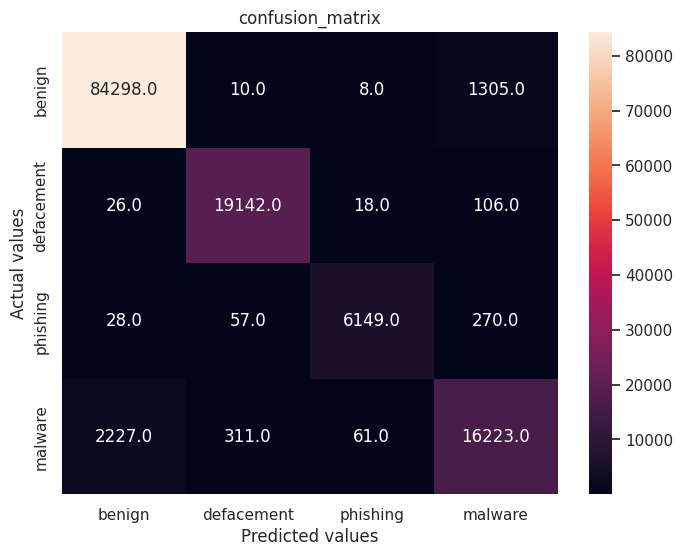

In [120]:
cm = confusion_matrix(y_test, y_pred_rf)
cm_df = pd.DataFrame(cm, index=['benign', 'defacement', 'phishing', 'malware'], 
                          columns =['benign', 'defacement', 'phishing', 'malware'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt=".1f")
plt.title("confusion_matrix")
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.show()

# Feature Importance

<Axes: >

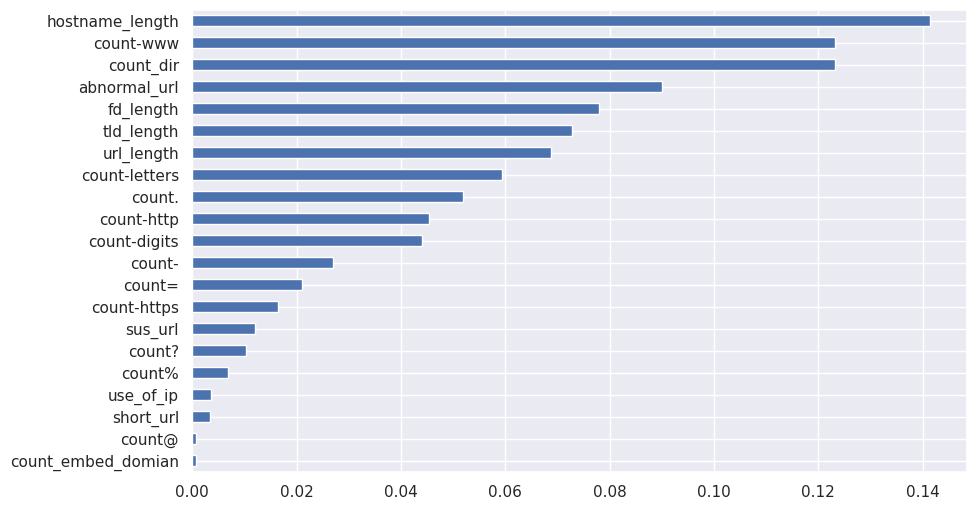

In [121]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind="barh",figsize=(10, 6))

# 1.2 Clustering Model

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster labels:  [0 0 1 ... 1 1 1]


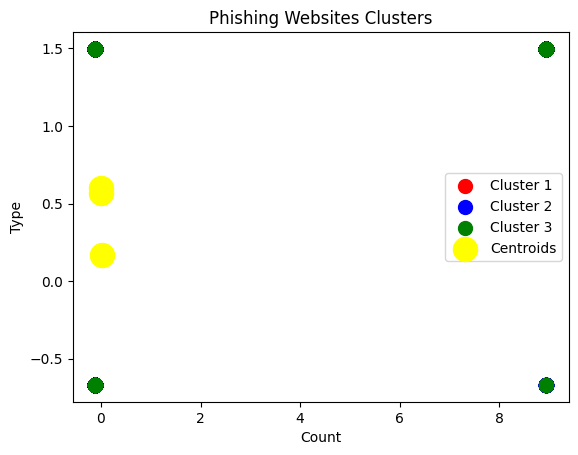

In [23]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Preprocessing
#X = data.iloc[:, :-1].values # Features
#y = data.iloc[:, -1].values # Target

sc = StandardScaler()
X = sc.fit_transform(X_train,y_train)

# K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
y_kmeans = kmeans.fit_predict(X_train)

# Results
print("Cluster labels: ", y_kmeans)

# Visualization (assuming 2 features)
# import matplotlib.pyplot as plt

plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Phishing Websites Clusters')
plt.xlabel('Count')
plt.ylabel('Type')
plt.legend()
plt.show()


# 2. XGBoost Model

In [122]:
#XGboost
xgb_c = xgb.XGBClassifier(n_estimators= 100)
xgb_c.fit(X_train,y_train)
y_pred_x = xgb_c.predict(X_test)
print(classification_report(y_test,y_pred_x,target_names=['benign', 'defacement','phishing','malware']))


score = metrics.accuracy_score(y_test, y_pred_x)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

      benign       0.97      0.99      0.98     85621
  defacement       0.97      0.99      0.98     19292
    phishing       0.97      0.92      0.94      6504
     malware       0.91      0.83      0.87     18822

    accuracy                           0.96    130239
   macro avg       0.96      0.93      0.94    130239
weighted avg       0.96      0.96      0.96    130239

accuracy:   0.962


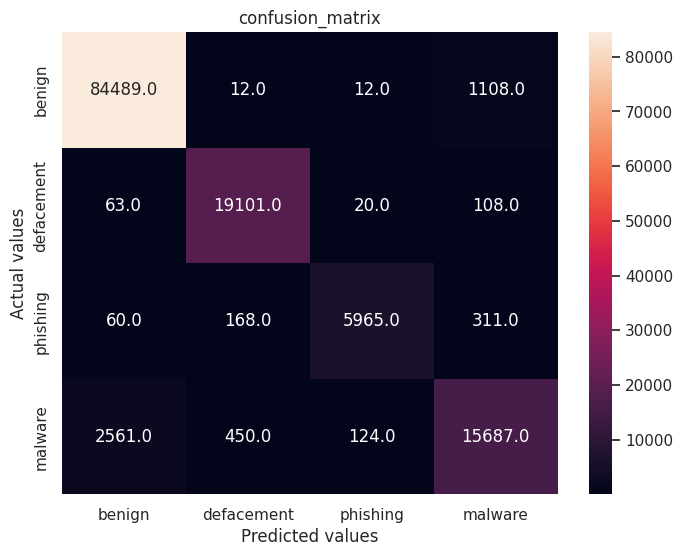

In [123]:
cm = confusion_matrix(y_test, y_pred_x)
cm_df = pd.DataFrame(cm, index=['benign', 'defacement', 'phishing', 'malware'], 
                          columns =['benign', 'defacement', 'phishing', 'malware'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt=".1f")
plt.title("confusion_matrix")
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.show()

<Axes: >

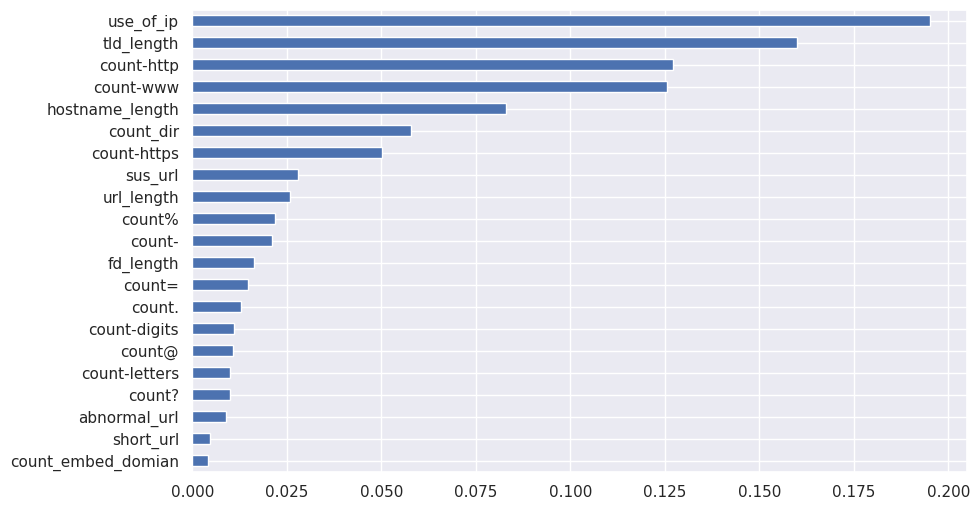

In [124]:
feat_importances = pd.Series(xgb_c.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind="barh",figsize=(10, 6))

# 3. Light GBM Classifier

In [125]:
# Light GBM Classifier
lgb = LGBMClassifier(objective='multiclass',boosting_type= 'gbdt',n_jobs = 5, 
          silent = True, random_state=5)
LGB_C = lgb.fit(X_train, y_train)


y_pred_lgb = LGB_C.predict(X_test)
print(classification_report(y_test,y_pred_lgb,target_names=['benign', 'defacement','phishing','malware']))

score = metrics.accuracy_score(y_test, y_pred_lgb)
print("accuracy:   %0.3f" % score)

/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


              precision    recall  f1-score   support

      benign       0.97      0.99      0.98     85621
  defacement       0.96      0.99      0.98     19292
    phishing       0.97      0.90      0.93      6504
     malware       0.90      0.83      0.86     18822

    accuracy                           0.96    130239
   macro avg       0.95      0.93      0.94    130239
weighted avg       0.96      0.96      0.96    130239

accuracy:   0.959


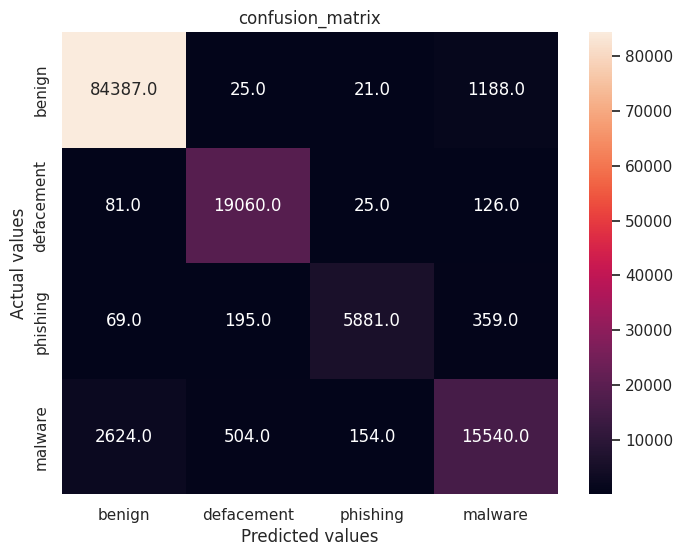

In [126]:
cm = confusion_matrix(y_test, y_pred_lgb)
cm_df = pd.DataFrame(cm, index=['benign', 'defacement', 'phishing', 'malware'], 
                          columns =['benign', 'defacement', 'phishing', 'malware'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt=".1f")
plt.title("confusion_matrix")
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.show()

<Axes: >

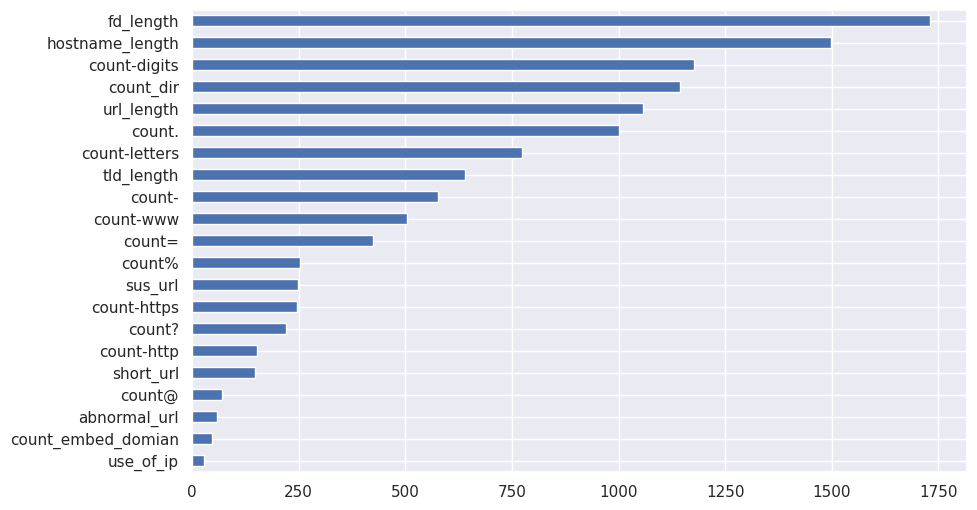

In [127]:
feat_importances = pd.Series(lgb.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind="barh",figsize=(10, 6))

# 4. Decision Tree Classifier

In [128]:
# Create a Decision Tree Classifier Model
from sklearn.tree import DecisionTreeClassifier

# create a decision tree classifier model
dtc_model = DecisionTreeClassifier()

# train the model on the training set
dtc_model.fit(X_train,y_train) 

# make predictions on the test set
y_pred =dtc_model.predict(X_test)

# evaluate the model performance
accuracy =accuracy_score(y_test,y_pred)
print("Accuracy: ",accuracy)
report = classification_report(y_test,y_pred)
print("Classification Report:\n",report)

Accuracy:  0.9573783582490651
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97     85621
           1       0.98      0.99      0.98     19292
           2       0.95      0.95      0.95      6504
           3       0.87      0.84      0.86     18822

    accuracy                           0.96    130239
   macro avg       0.94      0.94      0.94    130239
weighted avg       0.96      0.96      0.96    130239



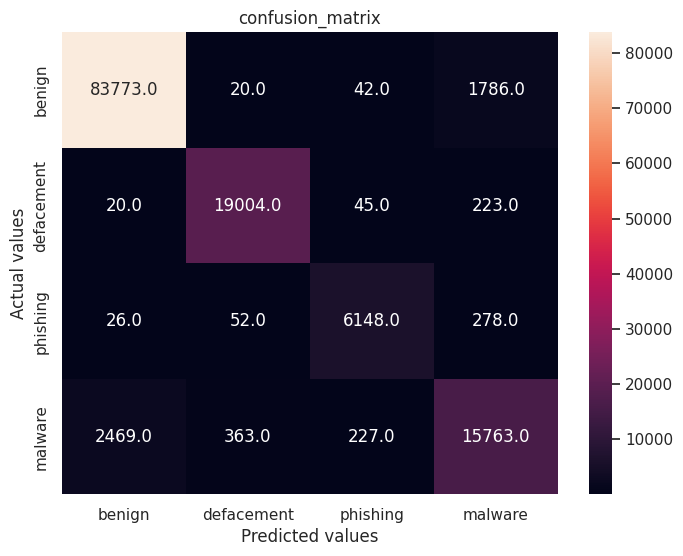

In [129]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['benign', 'defacement', 'phishing', 'malware'], 
                          columns =['benign', 'defacement', 'phishing', 'malware'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt=".1f")
plt.title("confusion_matrix")
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.show()

<Axes: >

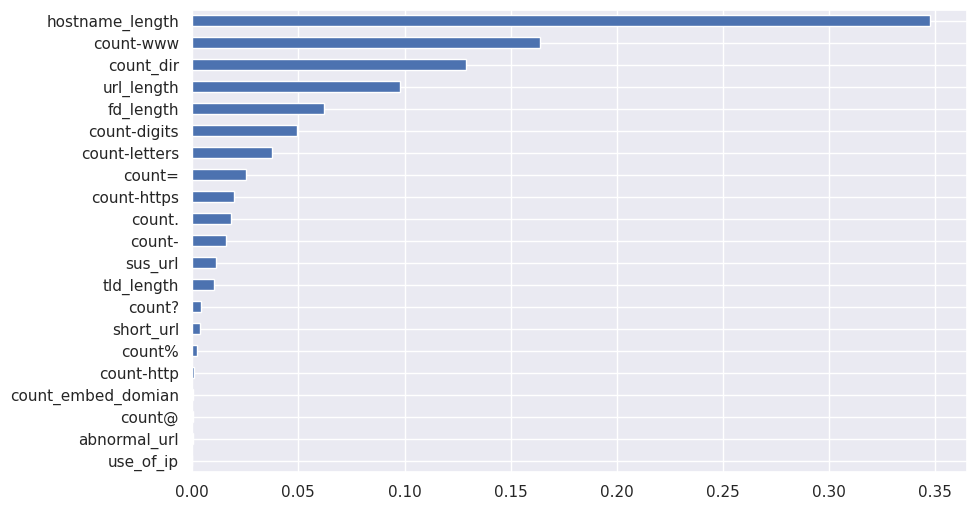

In [130]:
feat_importances = pd.Series(dtc_model.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind="barh",figsize=(10, 6))

# 5. Logistic Regression Model

In [131]:
# create a logistic regression model
from sklearn.linear_model import LogisticRegression
lr_model =LogisticRegression()
 
# train the model on the training set
lr_model.fit(X_train,y_train)
 
# make predictions on the test set
y_pred = lr_model.predict(X_test)
 
# evaluate the model performance
accuracy =accuracy_score(y_test,y_pred)
print("Accuracy: ",accuracy)
report =classification_report(y_test,y_pred)
print("Classification Report:\n",report)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy:  0.8277704834957271
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.97      0.92     85621
           1       0.77      0.86      0.81     19292
           2       0.82      0.55      0.66      6504
           3       0.53      0.23      0.32     18822

    accuracy                           0.83    130239
   macro avg       0.75      0.65      0.68    130239
weighted avg       0.80      0.83      0.80    130239



# 6. Supported Vector Machine

In [132]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

# Convert the URL strings into feature vectors using TfidfVectorizer
vectorizer =TfidfVectorizer()
X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)
 
# Train an SVM model on the training data
svm =SVC(kernel='linear')
svm.fit(X_train_vectors,y_train)
 
# Make predictions on the test data
y_pred = svm.predict(X_test_vectors)
 
# Evaluate the performance of the model
accuracy =accuracy_score(y_test,y_pred)
#precision =precision_score(y_test,y_pred)
#recall =recall_score(y_test,y_pred)
#f1 =f1_score(y_test,y_pred)
 
# evaluate the model performance
accuracy = accuracy_score(y_test,y_pred)
print("Accuracy: ",accuracy)
report =classification_report(y_test,y_pred)
print("Classification Report:\n",report)


ValueError: ignored

# Model prediction

In [ ]:
def main(url):
    
    status = []
    
    status.append(having_ip_address(url))
    status.append(abnormal_url(url))
    status.append(count_dot(url))
    status.append(count_www(url))
    status.append(count_atrate(url))
    status.append(no_of_dir(url))
    status.append(no_of_embed(url))
    
    status.append(shortening_service(url))
    status.append(count_https(url))
    status.append(count_http(url))
    
    status.append(count_per(url))
    status.append(count_ques(url))
    status.append(count_hyphen(url))
    status.append(count_equal(url))
    
    status.append(url_length(url))
    status.append(hostname_length(url))
    status.append(suspicious_words(url))
    status.append(digit_count(url))
    status.append(letter_count(url))
    status.append(fd_length(url))
    tld = get_tld(url,fail_silently=True)
      
    status.append(tld_length(tld))
    
    return status

# predict function 
def get_prediction_from_url(test_url):
    features_test = main(test_url)
    # Due to updates to scikit-learn, we now need a 2D array as a parameter to the predict function.
    features_test = np.array(features_test).reshape((1, -1))
    pred = lgb.predict(features_test)
    if int(pred[0]) == 0:
        
        res="SAFE"
        return res
    elif int(pred[0]) == 1.0:
        
        res="DEFACEMENT"
        return res
    elif int(pred[0]) == 2.0:
        res="PHISHING"
        return res
        
    elif int(pred[0]) == 3.0:
        
        res="MALWARE"
        return res

# Test Sample URL for Prediction

In [ ]:
# predicting sample raw URLs

urls = ['titaniumcorporate.co.za','en.wikipedia.org/wiki/North_Dakota']

for url in urls:
     print(get_prediction_from_url(url))